# Consistency training to counter subtle distribution shifts in the input data 

In [ ]:
!pip install -q tf-models-official tensorflow-addons
!pip install -q efficientnet
!pip install tfimm

clear_output()

In [6]:
from official.vision.image_classification.augment import RandAugment
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import efficientnet.tfkeras as efn
import tfimm

In [7]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10
CROP_TO = 224
RESIZE_TO = 512
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.0005
DROPOUT = 0.1
SEED = 1 
NFOLD = 5
VAL_FOLD = 0
TEST_FOLD = 1

GCS_PATH = 'gs://kds-57f9ca82c6ece747fdb97da243e70f5c8414ca9cf66a8576e6c00740'
VERBOSE = 1
train = pd.read_csv('train.csv')
N_CLASSES = train.species.nunique()
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/train/*.png')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/test/*.png')
STEPS_PER_EPOCH = len(TRAINING_FILENAMES)+len(TEST_FILENAMES) // BATCH_SIZE

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(SEED)

In [ ]:
from IPython.display import clear_output

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

clear_output()    

In [8]:
train = pd.read_csv('train.csv')

encoder = LabelEncoder()
train['labels'] = encoder.fit_transform(train.species)

gkf  = GroupKFold(n_splits = NFOLD)
train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train, groups = train.individual_id.tolist())):
    train.loc[val_idx, 'fold'] = fold

train.head(1)

,image,species,individual_id,labels,fold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,18,2


# Dataset

In [9]:
# Initialize `RandAugment` object with 2 layers of
# augmentation transforms and strength of 9.
augmenter = RandAugment(num_layers=2, magnitude=9)

def preprocess_train(image, label, noisy=True):
    # We first resize the original image to a larger dimension
    # and then we take random crops from it.
    img = tf.image.resize(image, [RESIZE_TO,RESIZE_TO])
    img = tf.cast(img, tf.float32)
    image = tf.image.random_crop(image, [CROP_TO, CROP_TO, 3])
    image = tf.image.random_flip_left_right(image)
    if noisy:
        image = augmenter.distort(image)
    return image, label

def preprocess_test(image, label):
    img = tf.image.resize(image, [CROP_TO, CROP_TO])
    img = tf.cast(img, tf.float32)
    return image, label

def decode_img(path):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(file_bytes, channels=3)
    return img

def load_dataset(filename, label):
    img = decode_img(filename)
    return img, label

In [10]:
valid_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == VAL_FOLD]['image'].str.split('.').values]
test_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == TEST_FOLD]['image'].str.split('.').values]
train_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['image'].str.split('.').values]

valid_labels = np.array(train[train['fold'] == VAL_FOLD]['labels']).reshape(-1,1)
test_labels = np.array(train[train['fold'] == TEST_FOLD]['labels']).reshape(-1,1)
train_labels = np.array(train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['labels']).reshape(-1,1)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# This dataset will be used to train the first model.
train_clean_ds = (
    train_ds.map(load_dataset, num_parallel_calls = AUTO)
    .cache()
    .shuffle(BATCH_SIZE * 10, seed=SEED)
    .map(lambda x, y: (preprocess_train(x, y, noisy=False)), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTO)
)

# This prepares the `Dataset` object to use RandAugment.
train_noisy_ds = (
    train_ds.map(load_dataset, num_parallel_calls = AUTO)
    .cache()
    .shuffle(BATCH_SIZE * 10, seed=42)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTO)
)

validation_ds = (
    valid_ds.map(load_dataset, num_parallel_calls = AUTO)
    .cache()
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.map(load_dataset, num_parallel_calls = AUTO)
    .cache()
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# This dataset will be used to train the second model.
consistency_training_ds = tf.data.Dataset.zip((train_clean_ds, train_noisy_ds))

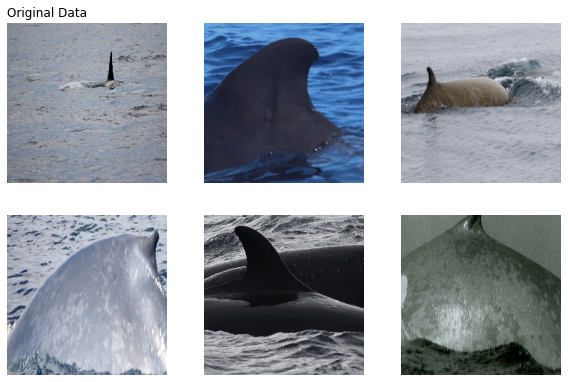

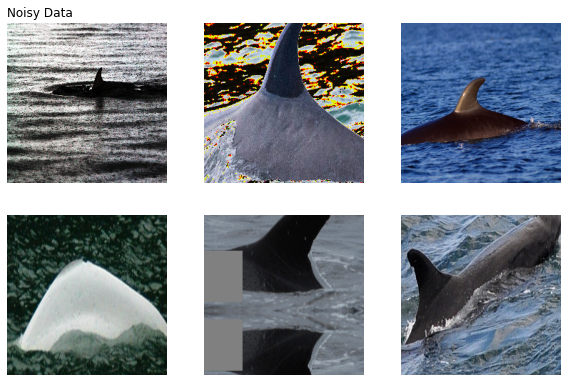

In [11]:
sample_images, sample_labels = next(iter(train_clean_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:6]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    if i==0:
      plt.title('Original Data', loc='left')
    plt.axis("off")

sample_images, sample_labels = next(iter(train_noisy_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:6]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    if i==0:
      plt.title('Noisy Data', loc='left')
    plt.axis("off")    

# Model 

In [ ]:
def get_training_model(num_classes=N_CLASSES):
    model_ = tfimm.create_model('resnet34d')
    model = tf.keras.Sequential(
        [
            layers.Input((CROP_TO, CROP_TO, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            model_,
            layers.Dense(num_classes, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
        ]
    )
    return model

initial_teacher_model = get_training_model()
initial_teacher_model.save_weights("initial_teacher_model.h5")    

# Train teacher model on clean images

Training uses Stochastic Weight Averaging which resembles geometric ensembling as used in Noisy Student Training.

In [ ]:
# Define the callbacks.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

SWA = tfa.optimizers.SWA

with strategy.scope():
  teacher_model = get_training_model()
  teacher_model.load_weights("initial_teacher_model.h5")
  teacher_model.compile(
    # Notice that we are wrapping our optimizer within SWA
    optimizer=SWA(tf.keras.optimizers.Adam(LEARNING_RATE)),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    )
  
history = teacher_model.fit(
    train_clean_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/10
478/478 [==============================] - 938s 2s/step - loss: 1.6216 - accuracy: 0.5323 - val_loss: 1.4151 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 2/10
478/478 [==============================] - 34s 70ms/step - loss: 0.9761 - accuracy: 0.7087 - val_loss: 0.9936 - val_accuracy: 0.7013 - lr: 0.0010
Epoch 3/10
478/478 [==============================] - 32s 68ms/step - loss: 0.7202 - accuracy: 0.7842 - val_loss: 0.8088 - val_accuracy: 0.7584 - lr: 0.0010
Epoch 4/10
478/478 [==============================] - 32s 68ms/step - loss: 0.5811 - accuracy: 0.8238 - val_loss: 0.7752 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 5/10
478/478 [==============================] - 33s 68ms/step - loss: 0.4890 - accuracy: 0.8544 - val_loss: 0.6764 - val_accuracy: 0.8025 - lr: 0.0010
Epoch 6/10
478/478 [==============================] - 33s 69ms/step - loss: 0.4340 - accuracy: 0.8688 - val_loss: 0.5939 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 7/10
478/478 [==============================] - 33s 6

# Train the student model on clean and noisy variant of same images

Training of the student model encourages a consistent predictions for clean as well as noisy images. The model is the same for student and teacher (unlike in knowledge distillation). The total loss is calculated as the average of student and distillation loss. 

In [ ]:
# Majority of the code is taken from:
# https://keras.io/examples/vision/knowledge_distillation/
class SelfTrainer(tf.keras.Model):
    def __init__(self, student, teacher):
        super(SelfTrainer, self).__init__()
        self.student = student
        self.teacher = teacher

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, temperature=3,
    ):
        super(SelfTrainer, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature

    def train_step(self, data):
        # Since our dataset is a zip of two independent datasets,
        # after initially parsing them, we segregate the
        # respective images and labels next.
        clean_ds, noisy_ds = data
        clean_images, _ = clean_ds
        noisy_images, y = noisy_ds

        # Forward pass of teacher
        teacher_predictions = self.teacher(clean_images, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(noisy_images, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            total_loss = (student_loss + distillation_loss) / 2

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`
        self.compiled_metrics.update_state(
            y, tf.nn.softmax(student_predictions, axis=1)
        )

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"total_loss": total_loss})
        return results

    def test_step(self, data):
        # During inference, we only pass a dataset consisting images and labels.
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Update the metrics
        self.compiled_metrics.update_state(y, tf.nn.softmax(y_prediction, axis=1))

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        return results


In [ ]:
# Define the callbacks.
# We are using a larger decay factor to stabilize the training.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=3, factor=0.5, monitor="val_accuracy"
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor="val_accuracy"
)

# Compile and train the student model.
with strategy.scope():

  self_trainer = SelfTrainer(student=get_training_model(), teacher=teacher_model)
  self_trainer.compile(
    # Notice we are *not* using SWA here.
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=["accuracy"],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
    distillation_loss_fn=tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE),
    temperature=10,
    )
  
history = self_trainer.fit(
    consistency_training_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/10
478/478 [==============================] - 718s 1s/step - accuracy: 0.3718 - total_loss: 1.1751 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 2/10
478/478 [==============================] - 40s 84ms/step - accuracy: 0.5225 - total_loss: 0.8905 - val_accuracy: 0.5906 - lr: 0.0010
Epoch 3/10
478/478 [==============================] - 40s 83ms/step - accuracy: 0.5955 - total_loss: 0.7495 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 4/10
478/478 [==============================] - 40s 84ms/step - accuracy: 0.6482 - total_loss: 0.6776 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 5/10
478/478 [==============================] - 40s 84ms/step - accuracy: 0.6867 - total_loss: 0.5989 - val_accuracy: 0.7531 - lr: 0.0010
Epoch 6/10
478/478 [==============================] - 40s 84ms/step - accuracy: 0.7160 - total_loss: 0.5427 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 7/10
478/478 [==============================] - 40s 84ms/step - accuracy: 0.7376 - total_loss: 0.5127 - val_accuracy: 0.8189 - lr: 

In [ ]:
_, t_acc = teacher_model.evaluate(test_ds, verbose=0)
s_acc = self_trainer.evaluate(test_ds, verbose=0)

print(f"Test accuracy without consistency training: {t_acc*100}%")
print(f"Test accuracy after consistency training: {s_acc*100}%")

Test accuracy without consistency training: 86.0585868358612%
Test accuracy after consistency training: 87.48897314071655%


#### The performance of the student does improve by around 1.7%. Training was aimed to give "consistent" predictions against data imperfections like random noise, contrast change, and blurring etc.